In [1]:
import numpy as np
import tensorflow as tf
tf.__version__

2023-06-19 11:36:39.956960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 11:36:40.922806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.12.0'

In [2]:
def process_text(file_path):
    text = open(path_to_file, 'r', encoding='utf-8', errors='replace').read()
    vocab = sorted(set(text))  # The unique characters in the file
    # Creating a mapping from unique characters to indices and vice versa
    char2idx = {u: i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    text_as_int = np.array([char2idx[c] for c in text])
    return text_as_int, vocab, char2idx, idx2char

In [3]:
def split_input_target(chunk):
    input_text, target_text = chunk[:-1], chunk[1:]
    return input_text, target_text

In [4]:
def create_dataset(text_as_int, seq_length=100, batch_size=64, buffer_size=10000):
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    dataset = char_dataset.batch(seq_length + 1, drop_remainder=True).map(split_input_target)
    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    return dataset

### Model1: 2 GRU layers, With Regularization, Adam optimization, Epoch set = 50

In [5]:
def build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(vocab_size)  # Default activation: 'linear'
    ])
    return model

In [6]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [7]:
def generate_text(model, char2idx, idx2char, start_string, generate_char_num=1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    # Low temperatures results in more predictable text, higher temperatures results in more surprising text.
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []  # Empty string to store our results
    model.reset_states()
    for i in range(generate_char_num):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)    # remove the batch dimension
        predictions /= temperature
        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        # We pass the predicted character as the next input to the model along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], axis=0)
        text_generated.append(idx2char[predicted_id])
    return start_string + ''.join(text_generated)

In [8]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=50)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 10:36:02.177205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5
2023-06-19 10:36:02.694931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 10:36:02.696327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/spli

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (64, None, 1024)          6297600   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                        

2023-06-19 10:36:03.024365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 10:36:03.025190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [3381940]
	 [[{{node Placeholder/_0}}]]
2023-06-19 10:36:03.312988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

523/523 [==============================] - 42s 66ms/step - loss: 1.6072 - accuracy: 0.5410
Epoch 2/50
523/523 [==============================] - 31s 56ms/step - loss: 1.2753 - accuracy: 0.6149
Epoch 3/50
523/523 [==============================] - 31s 56ms/step - loss: 1.2049 - accuracy: 0.6328
Epoch 4/50
523/523 [==============================] - 31s 57ms/step - loss: 1.1675 - accuracy: 0.6429
Epoch 5/50
523/523 [==============================] - 31s 56ms/step - loss: 1.1423 - accuracy: 0.6492
Epoch 6/50
523/523 [==============================] - 31s 56ms/step - loss: 1.1228 - accuracy: 0.6549
Epoch 7/50
523/523 [==============================] - 31s 57ms/step - loss: 1.1070 - accuracy: 0.6591
Epoch 8/50
523/523 [==============================] - 31s 56ms/step - loss: 1.0938 - accuracy: 0.6625
Epoch 9/50
523/523 [==============================] - 31s 56ms/step - loss: 1.0820 - accuracy: 0.6659
Epoch 10/50
523/523 [==============================] - 32s 57ms/step - loss: 1.0718 - accurac

2023-06-19 11:02:19.770415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:02:19.775397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:02:19.778372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            23296     
                                                                 
 gru_2 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dropout_2 (Dropout)         (1, None, 1024)           0         
                                                                 
 batch_normalization_2 (Batc  (1, None, 1024)          4096      
 hNormalization)                                                 
                                                                 
 gru_3 (GRU)                 (1, None, 1024)           6297600   
                                                                 
 dropout_3 (Dropout)         (1, None, 1024)           0         
                                                      

2023-06-19 11:02:20.109112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:02:20.112372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:02:20.114651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [10]:
plot_graphs(history,'accuracy')

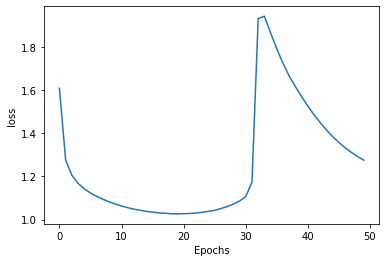

In [11]:
plot_graphs(history,'loss')

In [12]:
import time
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was a little obliepd. Ih he would
     me that I have with new than to Bellboruar. Well, then wathe get this right and chesp same the
     garden, away, and then?"

     "A   near to think it is only one varm. A few crobber to him into a society canding little
     well. This mateross it suppose. He had realized was devil of bold a
     self-time. Well, then?"

     "Ttered attense o'clock up, and in dazelate."





                                     THE ADVEOTE HOGin Berapow an ide to have gome not one.

     "Here shining to ke, a whiliver's the youngle?"

     "No."

     "Five thought at the Becowfled a bundle.

     "We order round passed in Barrdent, and down the way in the gre

### Model2: 2 GRU layers, With Regularization, Adam optimization, Epoch set = 25

In [9]:
# path_to_file = tf.keras.utils.get_file('nietzsche.txt', 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path_to_file = 'Data/SherlockHolmes.txt'

text_as_int, vocab, char2idx, idx2char = process_text(path_to_file)
dataset = create_dataset(text_as_int)
model = build_model(vocab_size=len(vocab))
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(dataset, epochs=25)
model.save_weights("gen_text_weights.h5", save_format='h5')
# To keep this prediction step simple, use a batch size of 1
model = build_model(vocab_size=len(vocab), batch_size=1)
model.load_weights("gen_text_weights.h5")
model.summary()

2023-06-19 11:13:33.423814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5
2023-06-19 11:13:34.152616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:13:34.156858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/spli

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           23296     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 batch_normalization (BatchN  (64, None, 1024)         4096      
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (64, None, 1024)          6297600   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                        

2023-06-19 11:13:34.482199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:13:34.485728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:13:34.488167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2023-06-19 11:13:34.913798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:13:34.915396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:13:34.917181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

523/523 [==============================] - 42s 64ms/step - loss: 1.6089 - accuracy: 0.5405
Epoch 2/25
523/523 [==============================] - 31s 56ms/step - loss: 1.2763 - accuracy: 0.6146
Epoch 3/25
523/523 [==============================] - 32s 57ms/step - loss: 1.2057 - accuracy: 0.6326
Epoch 4/25
523/523 [==============================] - 32s 57ms/step - loss: 1.1683 - accuracy: 0.6424
Epoch 5/25
523/523 [==============================] - 32s 57ms/step - loss: 1.1427 - accuracy: 0.6494
Epoch 6/25
523/523 [==============================] - 31s 57ms/step - loss: 1.1229 - accuracy: 0.6544
Epoch 7/25
523/523 [==============================] - 31s 57ms/step - loss: 1.1074 - accuracy: 0.6590
Epoch 8/25
523/523 [==============================] - 31s 56ms/step - loss: 1.0943 - accuracy: 0.6624
Epoch 9/25
523/523 [==============================] - 32s 57ms/step - loss: 1.0818 - accuracy: 0.6659
Epoch 10/25
523/523 [==============================] - 31s 56ms/step - loss: 1.0708 - accurac

2023-06-19 11:26:54.311493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:26:54.314716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:26:54.317947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            23296     
                                                                 
 gru_2 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dropout_2 (Dropout)         (1, None, 1024)           0         
                                                                 
 batch_normalization_2 (Batc  (1, None, 1024)          4096      
 hNormalization)                                                 
                                                                 
 gru_3 (GRU)                 (1, None, 1024)           6297600   
                                                                 
 dropout_3 (Dropout)         (1, None, 1024)           0         
                                                      

2023-06-19 11:26:54.588050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 11:26:54.589852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 11:26:54.591030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
plot_graphs(history,'accuracy')

In [13]:
plot_graphs(history, 'loss')

In [14]:
user_input = input("Write the beginning of the text, the program will complete it. Your input is: ")
start = time.time()
generated_text = generate_text(model, char2idx, idx2char, start_string=user_input, generate_char_num=1000)
end = time.time()
print(generated_text)
print('\nRun time:', end - start)

Write the beginning of the text, the program will complete it. Your input is: There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was
There is a line on the letter saying the object he saw was so horrible and he could not even figure out what it was so
     certain than the occurred to me.

     "After all, Sir Henry is, we shall give them some little mercy.
     You seem no tried to us from the maid, and there she was found in telling it, and then
     knew no argue or that. He passed the door of a man who is only nning the slam, and
     she and his Saxeer hailed the illusion and began to preserve it in
     beauty--and, so be."

     "If Eve Bradshaw," said Holmes, smiling.

     "It was a bit of distance. We thought it been the breakfast, and he lifted me a lempant and short times, a police convicthy, I near
     it the meaning of his experiment could not only this may
     be food. You'll have that all words came out on t